# Obtaining the ratio of our ttbar simulations to the ATLAS calculation


The goal of this notebook is to compare the our simulation of ttbar production in the MT2 variable to the numbers obtained by ATLAS.  The ratio of these distributions can then be used as a normalisation factor, applied to our simulation of the ttbar + axion distribution.

We are plotting $t \bar{t}$ production in the stransverse mass variable MT2.  The MG5 process definition is:

- $p p > t t~, (t > l+ vl b), (t~ > l- vl~ b~)$

The distribution is compared to ATLAS in https://www.hepdata.net/record/ins1844425?version=1, figure 11 (a).


Things to do before finalising this comparison and extracting the normaliation:


1. Apply the same cuts as in the exp paper
2. Generate more events, so that the stats in the tail are good
3. Change the process definition so that we use only different flavour leptons (11 a).  We can then redo this analysis with same flavour leptons only, and compare to figure 11 (b).
4. Apply the delta Phi boost cut in dummy_fct.f
5. Apply an 'ET miss significance' cut, or understand why this can be neglected

In [1]:
import awkward as ak
import hist
import numpy as np
import pylhe
from mt2 import mt2
import csv

### Input files, parameters

In [2]:
lumi = 139*1e3

In [8]:
dir_ttbar = './ttbar_events/'

### CSV reader for ATLAS dataset:

In [9]:
def csv_reader(filename):
    output = []
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            output.append(row)
        csvfile.close()

    return output

### Histogram normalisations

In [10]:
def read_sigma_nevents(dirname):
    filename = dirname + dirname.split('/')[-2]+'_tag_1_banner.txt'
    with open(filename,'r') as f:
        data = f.readlines()
    f.close()
    sigma = float(data[-4].split(' ')[-1])
    nevents = float(data[-5].split(' ')[-1])
    return sigma, nevents

Obtain normalisation factors for each histogram

In [11]:
sigma_sm, nevents_sm = read_sigma_nevents(dir_ttbar)
ww_sm = sigma_sm*lumi/nevents_sm

### Load events 

In [12]:
pylhe.register_awkward()
arr_sm = pylhe.to_awkward(pylhe.read_lhe_with_attributes(dir_ttbar+"unweighted_events.lhe"))

SM vectors and properties - ttbar

Leptons are at indices 6,9
Neutrinos are at indices 7,10

To do: generalise this somehow

In [90]:
#visible things
#Leptons are at index 6,9

vecL1SM = arr_sm.particles.vector[:,-3]   
vecL2SM = arr_sm.particles.vector[:,-6] 

massL1SM = 0.1
massL2SM = 0.1

pxL1SM = vecL1SM.px
pyL1SM = vecL1SM.py

pxL2SM = vecL2SM.px
pyL2SM = vecL2SM.py

#Invisible things
#neutrinos are at index 7,10
#Assume massless

vecMissSM = arr_sm.particles.vector[:,-2] + arr_sm.particles.vector[:,-5]
pmiss_xSM = vecMissSM.px
pmiss_ySM = vecMissSM.py

mmiss1SM = 0
mmiss2SM = 0
mmiss1SM

0

Calculate mt2

In [91]:
valSM = mt2(
        massL1SM, pxL1SM, pyL1SM,  # Visible 1: mass, px, py
    massL2SM, pxL2SM, pyL2SM,  # Visible 2: mass, px, py
    pmiss_xSM, pmiss_ySM,  # Missing transverse momentum: x, y
    mmiss1SM, mmiss2SM)  # Invisible 1 mass, invisible 2 mass

# Load data from ATLAS dataset:

In [92]:
data = csv_reader('HEPData-ins1844425-v1-Figure_11a.csv')

binC_ttbar = []
binL_ttbar = []
binH_ttbar = []
data_ttbar = []
unc_ttbar = []

for item in data[30:37]:
    binL_ttbar.append(float(item[1]))
    binH_ttbar.append(float(item[2]))
    binC_ttbar.append(float(item[0]))
    data_ttbar.append(float(item[3]))
    unc_ttbar.append(float(item[5]))
    
width = np.array(binH_ttbar)-np.array(binL_ttbar)
print(binL_ttbar)

[100.0, 110.0, 120.0, 140.0, 160.0, 180.0, 220.0]


# Plot histograms

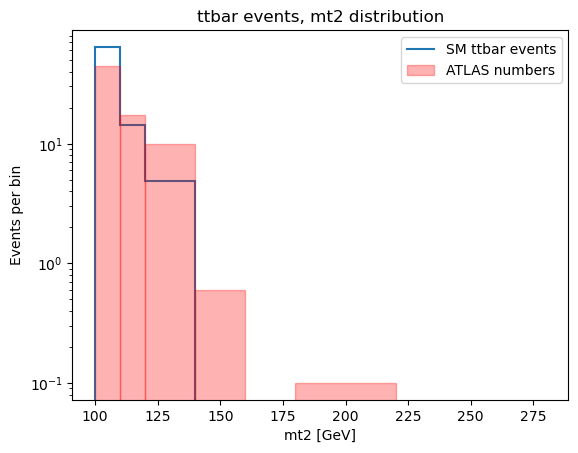

In [97]:
#axis1 = hist.axis.Regular(bins=80, start=100, stop=150, name="smtr_SM");
axis1 = hist.axis.Variable([100,110, 120, 140, 160, 180, 220, 280],name = "smtr_SM")
hist1 = hist.Hist(axis1, );
hist1.fill(smtr_SM=valSM, weight=ww_sm); #update this with off-shell events which actually have a distribution here


artists = hist1.plot1d(label='SM ttbar events');
ax = artists[0].stairs.axes;

ax.bar(binC_ttbar, data_ttbar, align='center', width=width, facecolor='red', edgecolor='red', alpha=0.3, label='ATLAS numbers')

ax.set_yscale("linear");
ax.set_xlabel(r"");
ax.set_ylabel("Events per bin");
ax.set_title('ttbar events, mt2 distribution');
ax.set_xlabel('mt2 [GeV]');
ax.set_yscale('log')
ax.legend()

# Compute ratio:

In [94]:
hist1_data = []

for item in hist1:
    hist1_data.append(item)

hist1_data = np.array(hist1_data);
ratio = np.divide(hist1_data, data_ttbar);

/var/folders/xc/fyhlb6b5561216g9lrn3f_jr0000gp/T/ipykernel_96638/2743742107.py:7: RuntimeWarning: invalid value encountered in true_divide
  ratio = np.divide(hist1_data, data_ttbar);


(100.0, 300.0)

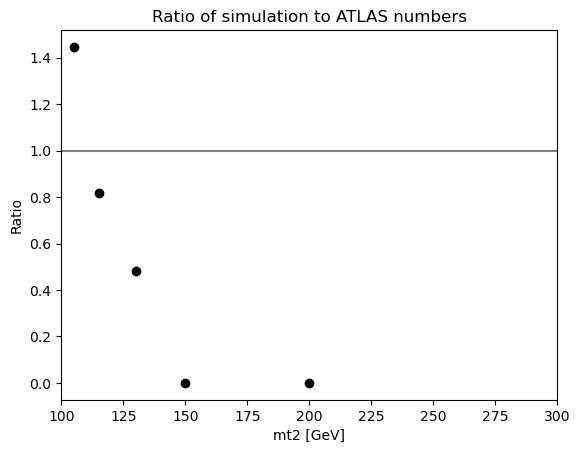

In [96]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

ax.plot(binC_ttbar, ratio,'ko',label='ratio')
ax.hlines(y=1.0, xmin=80, xmax=300, color='grey')
ax.set_yscale("linear");
ax.set_xlabel(r"");
ax.set_ylabel("Ratio");
ax.set_title('Ratio of simulation to ATLAS numbers');
ax.set_xlabel('mt2 [GeV]');
ax.set_xlim([100,300])